In [1]:
import pandas as pd
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch
from DataLoader import Dataset
from Model import Transformer, AdamWarmup
from train import train
import torch.nn as nn
from joblib import load
from tools import *
import matplotlib.pyplot as plt
from eval import eval
import os
from datetime import datetime

In [2]:
df = pd.read_csv('Data/close-price/btc-usdt-1hr.csv').iloc[:,:6]
df['Open Time'] = pd.to_datetime(df['Open Time'], unit= 's')
df

,Open Time,Open,High,Low,Close,Volume
0,2021-01-01 00:00:00,28923.63,29031.34,28690.17,28995.13,2311.811445
1,2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,5403.068471
2,2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,2384.231560
3,2021-01-01 03:00:00,29195.25,29367.00,29150.02,29278.40,1461.345077
4,2021-01-01 04:00:00,29278.41,29395.00,29029.40,29220.31,2038.046803
...,...,...,...,...,...,...
5817,2021-08-31 20:00:00,47300.00,47322.71,46914.26,46992.60,1375.538340
5818,2021-08-31 21:00:00,46992.60,47200.00,46833.00,46911.50,1488.115700
5819,2021-08-31 22:00:00,46911.49,47104.96,46744.57,47088.84,1359.884290
5820,2021-08-31 23:00:00,47091.36,47345.00,46993.00,47100.89,1242.528870


No handles with labels found to put in legend.


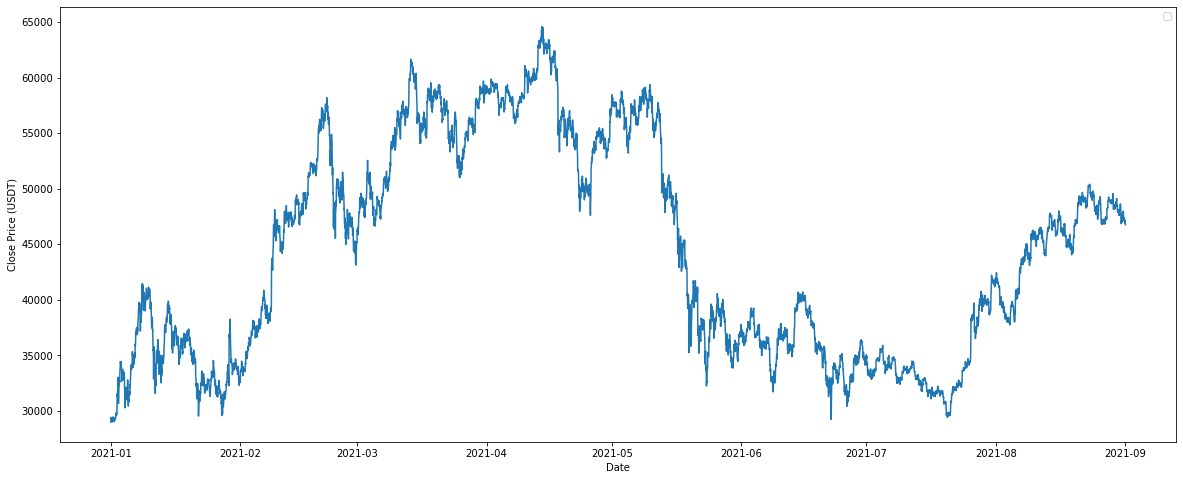

In [3]:
plt.figure(figsize=(20,8))
plt.plot(df['Open Time'], df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price (USDT)')
plt.legend()

In [4]:
#Parameters
epochs = 100
d_model = 8
nhead = 8
num_encode_layer = 3
num_decode_layer = 0 #Only need the encoder
len_input = 48
dim_feedforward = 1024
len_output = 1
warmup_steps = 400
dropout = 0.2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Dataloader
train_dataset = Dataset('Data/close-price/train-btc-dataset.csv', len_input)
train_loader = DataLoader(train_dataset, batch_size= 1)

val_dataset = Dataset('Data/close-price/valid-btc-dataset.csv', len_input)
val_loader = DataLoader(train_dataset, batch_size= 1)

#Create model object
model = Transformer(d_model,
                    nhead = nhead,
                    num_encode_layer= num_encode_layer,
                    num_decode_layer= num_decode_layer,
                    dim_feedforward= dim_feedforward,
                    len_output = len_output,
                    dropout= dropout,
                    batch_first= True)

model.double().to(device)

#Create Adam optimizer with learning rate warmup
adam_optimizer = torch.optim.Adam(model.parameters(), lr = 0, betas=(0.9,0.98), eps = 1e-9)
adam_warmup= AdamWarmup(d_model, warmup_steps= warmup_steps, optimizer= adam_optimizer)

#Loss function
criterion = nn.MSELoss(reduction='none')

train_loss_hist = []
val_loss_hist = []
min_val_loss = float('inf')

#training loop
for epoch in range(epochs):
    train_loss, val_loss = train(train_loader= train_loader,
                                val_loader= val_loader,
                                len_input= len_input,
                                len_output= len_output,
                                model= model,
                                optim= adam_warmup,
                                criterion= criterion,
                                epoch= epoch,
                                device= device)
#     break
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        best_state = {
            'epoch': epoch + 1,
            'model': model.state_dict(),
            'optimizer': adam_optimizer.state_dict(),
            'training loss': train_loss,
            'validation loss': val_loss
        }

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)

    print('Epoch: [{}/{}] \t Trainig Loss: {:.3f}e-3 \t Validation Loss: {:.3f}e-3'.format(epoch+1, epochs, train_loss*1000, val_loss*1000))
    
    timestamp = int(datetime.now().timestamp())
    if early_stop(val_loss_hist, patience= 10):
        maybe_make_dir('checkpoints/close-price')
        torch.save(best_state, f'checkpoints/close-price/{timestamp}-{num_encode_layer}L-{len_input}HR-{dim_feedforward}FF-{warmup_steps}LRWU-{dropout}DR-Price.tar')
        break
    elif epoch+1 == epochs:
        maybe_make_dir('checkpoints/close-price')
        torch.save(best_state, f'checkpoints/close-price/{timestamp}-{num_encode_layer}L-{len_input}HR-{dim_feedforward}FF-{warmup_steps}LRWU-{dropout}DR-Price.tar')



Epoch: [1/100] 	 Trainig Loss: 9.817e-3 	 Validation Loss: 165.433e-3
Epoch: [2/100] 	 Trainig Loss: 1.938e-3 	 Validation Loss: 114.239e-3
Epoch: [3/100] 	 Trainig Loss: 1.864e-3 	 Validation Loss: 135.637e-3
Epoch: [4/100] 	 Trainig Loss: 2.020e-3 	 Validation Loss: 128.819e-3
Epoch: [5/100] 	 Trainig Loss: 2.069e-3 	 Validation Loss: 120.469e-3
Epoch: [6/100] 	 Trainig Loss: 2.034e-3 	 Validation Loss: 101.463e-3
Epoch: [7/100] 	 Trainig Loss: 1.371e-3 	 Validation Loss: 62.023e-3
Epoch: [8/100] 	 Trainig Loss: 1.439e-3 	 Validation Loss: 51.543e-3
Epoch: [9/100] 	 Trainig Loss: 1.281e-3 	 Validation Loss: 48.850e-3
Epoch: [10/100] 	 Trainig Loss: 1.126e-3 	 Validation Loss: 47.220e-3
Epoch: [11/100] 	 Trainig Loss: 1.106e-3 	 Validation Loss: 41.815e-3
Epoch: [12/100] 	 Trainig Loss: 1.122e-3 	 Validation Loss: 38.665e-3
Epoch: [13/100] 	 Trainig Loss: 1.127e-3 	 Validation Loss: 35.372e-3
Epoch: [14/100] 	 Trainig Loss: 1.164e-3 	 Validation Loss: 36.376e-3
Epoch: [15/100] 	 Train

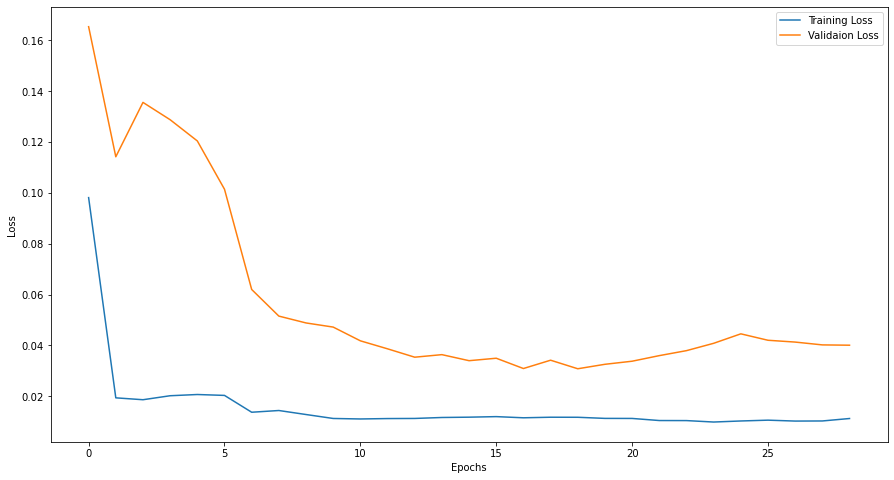

In [5]:
plt.figure(figsize=(15,8))
plt.plot(np.array(train_loss_hist)*10, label= 'Training Loss')
plt.plot(np.array(val_loss_hist), label= 'Validaion Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Prediction ended


Text(0.5, 1.0, 'Train Result')

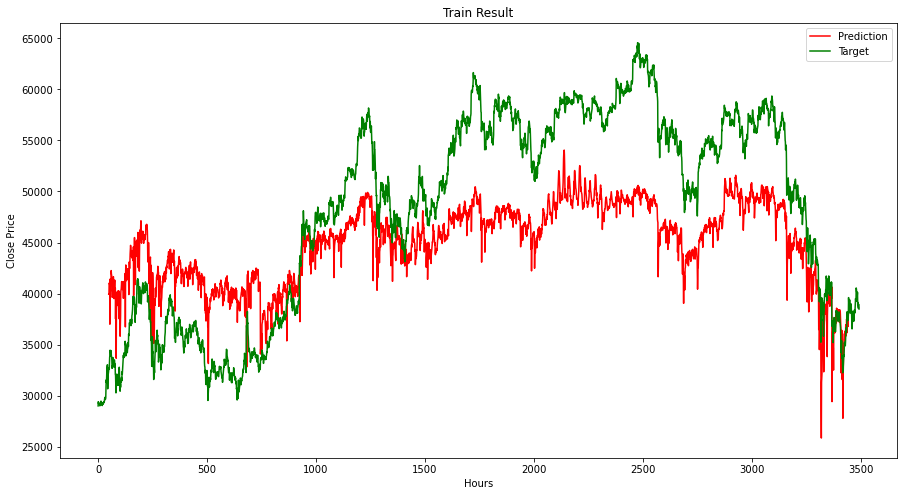

In [11]:
d_model = 8
nhead = 8
num_encode_layer = 3
num_decode_layer = 0 #Only need the encoder
len_input = 48
dim_feedforward = 1024
len_output = 1
warmup_steps = 400
dropout = 0.2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scaler = load('scalers/train-scaler-price.joblib')

model = Transformer(d_model,
                    nhead = nhead,
                    num_encode_layer= num_encode_layer,
                    num_decode_layer= num_decode_layer,
                    dim_feedforward= dim_feedforward,
                    len_output = len_output,
                    dropout= dropout,
                    batch_first= True)

checkpoint = os.listdir('checkpoints/close-price')[0]
best_state = torch.load(f'checkpoints/close-price/{checkpoint}')
model.load_state_dict(best_state['model'])
model.double().to(device)

adam_optimizer = torch.optim.Adam(model.parameters(), lr = 0, betas=(0.9,0.98), eps = 1e-9)
adam_warmup= AdamWarmup(d_model, warmup_steps= warmup_steps, optimizer= adam_optimizer)
criterion = nn.MSELoss(reduction= 'none')



train_dataset = Dataset('Data/close-price/train-btc-dataset.csv', len_input)
train_loader = DataLoader(train_dataset, batch_size= 1)

train_pred_hist, train_loss_hist = eval(train_loader, len_input, len_output, model, scaler, criterion, device=device)

for i in range(len(train_pred_hist)):
    train_pred_hist[i] = (train_pred_hist[i] * scaler.data_range_[0]) + scaler.data_min_[0] 
    
train_df = pd.read_csv('Data/close-price/train-btc-raw.csv')
train_pred_close = {'Pred Close' : train_pred_hist}
train_pred_df = pd.DataFrame(train_pred_close)
train_df['Pred Close'] = train_pred_df.shift(len_input + len_output)

plt.figure(figsize=(15,8))
plt.xlabel('Hours')
plt.ylabel('Close Price')
plt.plot(train_df['Pred Close'], label= 'Prediction', color= 'r')
plt.plot(train_df['Close'], label= 'Target', color= 'g')
plt.legend()
plt.title('Train Result')

Prediction ended


Text(0.5, 1.0, 'Validation Result')

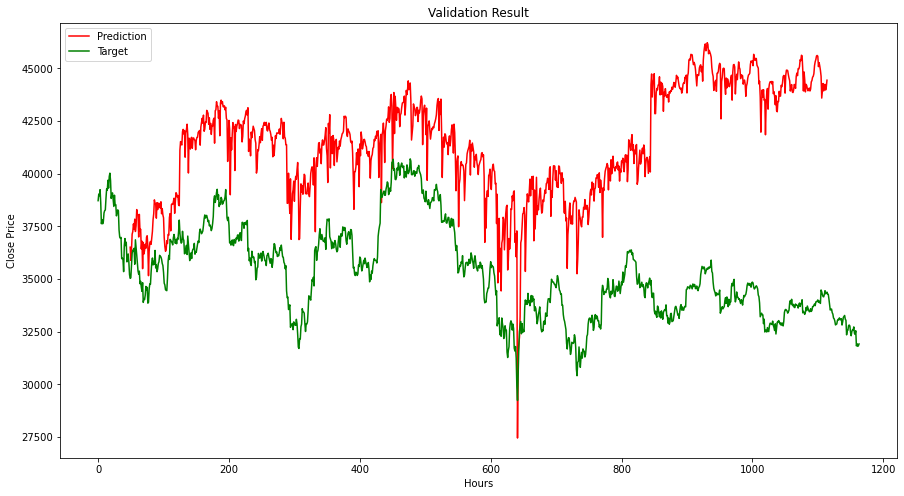

In [13]:
d_model = 8
nhead = 8
num_encode_layer = 3
num_decode_layer = 0 #Only need the encoder
len_input = 48
dim_feedforward = 1024
len_output = 1
warmup_steps = 400
dropout = 0.2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scaler = load('scalers/train-scaler-price.joblib')

model = Transformer(d_model,
                    nhead = nhead,
                    num_encode_layer= num_encode_layer,
                    num_decode_layer= num_decode_layer,
                    dim_feedforward= dim_feedforward,
                    len_output = len_output,
                    dropout= dropout,
                    batch_first= True)

checkpoint = os.listdir('checkpoints/close-price')[0]
best_state = torch.load(f'checkpoints/close-price/{checkpoint}')
model.load_state_dict(best_state['model'])
model.double().to(device)

adam_optimizer = torch.optim.Adam(model.parameters(), lr = 0, betas=(0.9,0.98), eps = 1e-9)
adam_warmup= AdamWarmup(d_model, warmup_steps= warmup_steps, optimizer= adam_optimizer)
criterion = nn.MSELoss(reduction= 'none')



val_dataset = Dataset('Data/close-price/valid-btc-dataset.csv', len_input)
val_loader = DataLoader(val_dataset, batch_size= 1)

val_pred_hist, val_loss_hist = eval(val_loader, len_input, len_output, model, scaler, criterion, device=device)

for i in range(len(val_pred_hist)):
    val_pred_hist[i] = (val_pred_hist[i] * scaler.data_range_[0]) + scaler.data_min_[0] 
    
val_df = pd.read_csv('Data/close-price/valid-btc-raw.csv')
val_pred_close = {'Pred Close' : val_pred_hist}
val_pred_df = pd.DataFrame(val_pred_close)
val_df['Pred Close'] = val_pred_df.shift(len_input + len_output)

plt.figure(figsize=(15,8))
plt.xlabel('Hours')
plt.ylabel('Close Price')
plt.plot(val_df['Pred Close'], label= 'Prediction', color= 'r')
plt.plot(val_df['Close'], label= 'Target', color= 'g')
plt.legend()
plt.title('Validation Result')

Text(0.5, 1.0, 'Result')

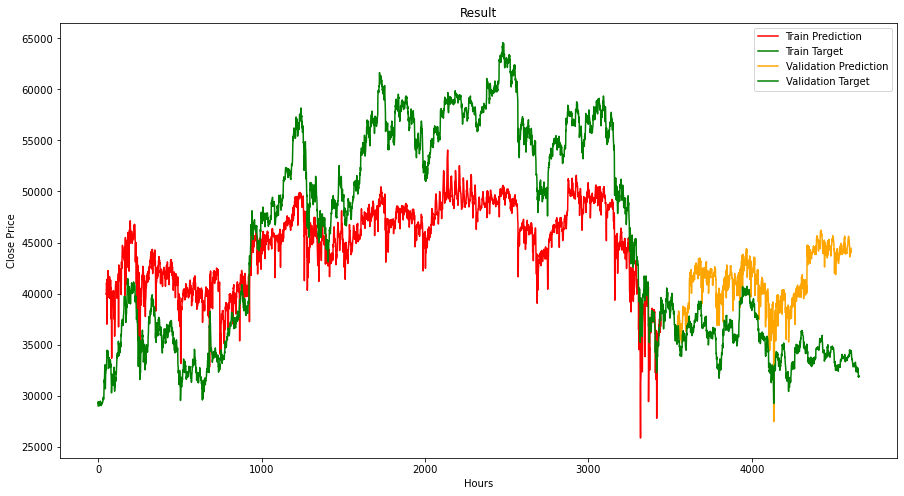

In [15]:
plt.figure(figsize=(15,8))
plt.xlabel('Hours')
plt.ylabel('Close Price')
plt.plot(train_df['Pred Close'], label= 'Train Prediction', color= 'r')
plt.plot(train_df['Close'], label= 'Train Target', color= 'g')
plt.plot([None]*len(train_df) + list(val_df['Pred Close']), label= 'Validation Prediction', color= 'orange')
plt.plot([None]*len(train_df) + list(val_df['Close']), label= 'Validation Target', color= 'g')
plt.legend()
plt.title('Result')